In [29]:
%load_ext autoreload
%autoreload 2


import tensorflow as tf
from tensorflow  import keras
import tensorflow_hub as hub
import numpy as np

import librosa 
from util import WavDataset
import matplotlib.pyplot as plt

import h5py
from pathlib import Path
from config import INTERMEDIATE, MODEL_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
np.random.seed(0)
hdf5_dataset = h5py.File(INTERMEDIATE / 'train.hdf5', 'r')
random_chunks = np.array(hdf5_dataset)
np.random.shuffle(random_chunks)

In [3]:
X_shape = (10, 1024)
Y_shape = (10, 4)

def chunk_generator():
    for chunk in random_chunks:
        chunk_group = hdf5_dataset[chunk]
        yield (
            np.array(chunk_group['X']), 
            np.array(chunk_group['Y']).T) 

raw_dataset = tf.data.Dataset.from_generator(
    chunk_generator,
    output_signature=(
        tf.TensorSpec(shape=X_shape, dtype=tf.float32),
        tf.TensorSpec(shape=Y_shape, dtype=tf.bool)))

# test
for s in raw_dataset.take(32):
    X, Y = s
    print(np.array(X).sum(), np.array(Y).sum(), end="\t\t")

458.73566 0		594.2076 0		746.2246 0		531.56323 

2024-09-09 11:10:02.884485: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0		657.0123 0		626.8448 0		664.3427 4		531.1446 0		777.21875 0		763.9229 0		493.90265 0		692.4295 0		566.7892 0		554.7632 0		578.3624 0		545.44275 0		787.87085 0		471.79166 0		701.3546 0		568.9809 0		637.3032 3		641.09607 0		561.34283 0		594.9181 0		801.41156 0		740.50226 0		781.42566 0		628.4475 0		667.9726 0		725.094 0		635.2217 0		614.97064 0		

In [185]:
from keras.layers import Input, Dense, BatchNormalization
import tensorflow_addons as tfa

# simple DNN head for YAMnet embeddings
model = keras.Sequential(
    [
        Input(shape=(10, 1024)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(4, activation='sigmoid')
    ]
)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  
    metrics=[
        'accuracy', 'SparseCategoricalAccuracy', # testing
        keras.metrics.Recall(thresholds=0.5),
        keras.metrics.Precision(thresholds=0.5),
        tf.keras.metrics.AUC()
    ]
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 10, 256)           262400    
                                                                 
 dense_60 (Dense)            (None, 10, 128)           32896     
                                                                 
 batch_normalization_7 (Batc  (None, 10, 128)          512       
 hNormalization)                                                 
                                                                 
 dense_61 (Dense)            (None, 10, 64)            8256      
                                                                 
 batch_normalization_8 (Batc  (None, 10, 64)           256       
 hNormalization)                                                 
                                                                 
 dense_62 (Dense)            (None, 10, 4)           

In [187]:
# 133921 chunks
# 4185 batches

from tensorflow.keras.callbacks import TensorBoard
import pandas as pd

model_dir = MODEL_DIR / "50e_initial_ds"
model_dir.mkdir(exist_ok=True)
EPOCHS = 50
BATCH = 32

## TODO active learning base
# # start with 30% 
# split = 0.3 * 
# AL_labelled_chunks = random_chunks
# AL_unlabelled_chunks = random_chunks # pretending these arent labeled for AL benchmarking

# split
n_chunks =  133921 
test_cut = int(n_chunks * 0.8)
valid_cut = int(cut * 0.8) 

train_valid_dataset = raw_dataset.take(test_cut)
test_dataset = raw_dataset.skip(test_cut)
train_dataset = train_valid_dataset.take(valid_cut)
validation_dataset = train_valid_dataset.skip(valid_cut)

# callbacks
log_dir = model_dir / "logs"
tensorboard_callback = TensorBoard(log_dir=log_dir)
checkpoint_path = model_dir / "training" / "model.ckpt"    
Path(checkpoint_path).parent.mkdir(exist_ok=True)                
cp_callback = keras.callbacks.ModelCheckpoint(                   
    filepath=checkpoint_path, save_weights_only=True, verbose=1  
)                                                                

# fit
print("/4185 (per epoch)")
history = model.fit(
    train_dataset.batch(BATCH).prefetch(100), 
    validation_data=validation_dataset.batch(BATCH).prefetch(100),
    epochs=EPOCHS, 
    verbose=1,
    callbacks=[tensorboard_callback, cp_callback])

df = pd.DataFrame(history.history)
df.to_csv("logs/history.csv")
model.save(model_dir / 'model.keras')

/4185 (per epoch)
Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 817, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/compile_utils.py", line 460, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/metrics_utils.py", line 73, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/metrics.py", line 177, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/metrics.py", line 725, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/metrics.py", line 3601, in sparse_categorical_accuracy
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[2], expected a dimension of 1, got 4 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](Cast_4)' with input shapes: [?,10,4].


<Axes: >

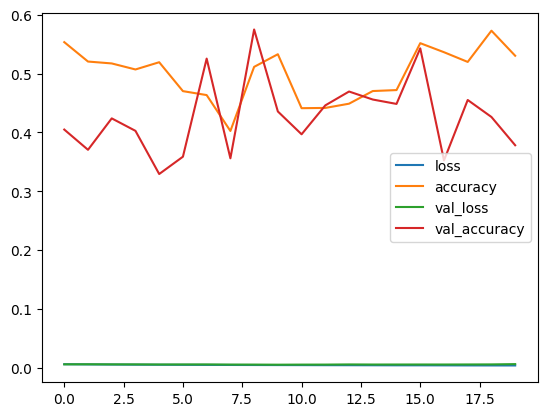

In [33]:
pd.DataFrame(history.history).plot()

In [102]:
import soundfile as sf

def read_audio_section(filename, start_time, stop_time):
    track = sf.SoundFile(filename)
    can_seek = track.seekable()
    if not can_seek:
        raise ValueError("Not compatible with seeking")

    sr = track.samplerate
    start_frame = sr * start_time
    frames_to_read = sr * (stop_time - start_time)
    track.seek(start_frame)
    audio_section = track.read(frames_to_read)
    return audio_section, sr

In [ ]:
import numpy as np
import librosa
from util import WavDataset
import matplotlib.pyplot as plt
from matplotlib import patches

def view_annotations(n=3):
   
    ds = WavDataset()
    
    
    for c in random_chunks[:6000]:
        g = hdf5_dataset[c]
        X, Y = g['X'], g['Y']
        
        start_s = g.attrs['start_time']
        end_s = g.attrs['end_time']
        rec = g.attrs['recording']
        label_counts = g.attrs['classwize_labeled_frame_counts']
        if sum(label_counts) == 0:
            continue # ignore if not annotated
            
        print(f"label counts = {label_counts}")
        
        # spectrogram from wavfile
        y, sr = read_audio_section(ds[rec], start_s, end_s)
        y = librosa.resample(y, orig_sr=sr, target_sr=16_000)
        S = librosa.stft(y)
        S = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S, y_axis='linear')
        
        # predictions for train ds
        X = np.expand_dims(X, axis=0) # for batch dim
        Y_pred = model(X)[0]
        Y_pred = np.array(Y_pred > 0.03)
        if Y_pred.sum() == 0:
            print('failure')
            continue

        row_idx, col_idx = np.where(Y_pred == 1)

        # lines
        frame_hop = 0.5
        for label_idx, row_idx in zip(col_idx, row_idx):
            seconds = frame_hop * row_idx
            spec_frame = librosa.time_to_frames(seconds)
            width = librosa.time_to_frames(0.5)
            
            print(spec_frame)

            #          trill   nr      traig    upsweep
            colours = ['red', 'blue', 'green', 'yellow']
            # plt.vlines(
            #     spec_frame, 
            #     linestyles='dashed', 
            #     colors=colours[label_idx], 
            #     ymin=0, ymax=8_000, label='TEST')

            rect = patches.Rectangle(
                (spec_frame - width, 0),  
                width, 
                20_000,  # Height
                linewidth=1,
                edgecolor='none',
                facecolor=colours[label_idx],
                alpha=0.2 
            )
            plt.gca().add_patch(rect)

        
        plt.show()
        
view_annotations()
